In [1]:
import pandas as pd
import numpy as np
import re
from string import punctuation

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

In [2]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Preprocessing Data

In the basic data preprocessing, columns of text, keywords, and locations were combined. In fact, this is not particularly good, because the importance of the first two columns is lost.

In [3]:
def preprocessing_data(df):
    df.fillna({"keyword": '', "location": ''}, inplace=True)
    

    df['text'] = df['keyword'] + ' ' + df['location'] + ' ' + df['text'] 
    df.drop("keyword", inplace= True, axis=1)
    df.drop("location", inplace= True, axis=1)

In [4]:
df.drop('id', inplace= True, axis= 1)

preprocessing_data(df)
preprocessing_data(df_test)

train, test = train_test_split(df, test_size=0.3, random_state=42)

# BoW, TF_IDF solution


TweetTokenizer was chosen as the basic tokenizer (I think it makes no sense to explain why this particular tokenizer is used). In the tokenizer, we get rid of various special characters, as well as the most frequent words that do not carry any information. Also, stemming was chosen between lemmatizer and stemming, as it is the least sensitive to context. PorterStemmer was chosen as the streamer.

In [5]:
def CustomTokenizer(text: str) -> list[str]:
    text_lower = text.lower()
    text_lower_tokenized = TweetTokenizer().tokenize(text_lower)
    
    needed_pattern = re.compile(rf'^[#]?[a-z]+$|[{punctuation}]?[()][{punctuation}]?')
    text_tokenized_latin = list(map(lambda x: needed_pattern.findall(x), text_lower_tokenized))
    text_tokenized_latin_needed = list(filter((lambda y: len(y) > 0), text_tokenized_latin)) 
    stopwords_s = stopwords.words('english')
    text_without_stopwords = list(filter((lambda y: y[0] not in stopwords_s), text_tokenized_latin_needed))
    
    stemmer = PorterStemmer()
    text_stemmed = [stemmer.stem(w[0]) for w in text_without_stopwords]

    return text_stemmed

In [6]:
def find_best_estimator(X_train, y_train, X_test, y_test):
    alphas = np.logspace(-1, 3, 10)
    searcher = GridSearchCV(LogisticRegression(), [{'C': alphas, 'max_iter': [500]}],
                            scoring='f1', cv=5, n_jobs=-1)
    searcher.fit(X_train, y_train)

    best_alpha = searcher.best_params_["C"]
    print("Best alpha = %.4f" % best_alpha)

    model = LogisticRegression(C=best_alpha, max_iter=500)
    model.fit(X_train, y_train)

    print("Train f1-score = %.4f" % f1_score(y_train, model.predict(X_train)))
    print("Test f1-score = %.4f" % f1_score(y_test, model.predict(X_test)))

    return model

In [7]:
cnt_vec = CountVectorizer(ngram_range=(1, 1), tokenizer=CustomTokenizer)

bow_train = cnt_vec.fit_transform(train['text'])
bow_test = cnt_vec.transform(test['text'])

bow_Test = cnt_vec.transform(df_test['text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
best_estimator = find_best_estimator(bow_train, train['target'], bow_test, test['target'])

predictions = best_estimator.predict(bow_Test)

results = pd.DataFrame({
    'id': df_test['id'].values,
    'target': predictions
})

results.to_csv('predictions_bow.csv', index=False)

Best alpha = 0.7743
Train f1-score = 0.9413
Test f1-score = 0.7554


In [9]:
tf_idf = TfidfVectorizer(tokenizer=CustomTokenizer, max_df=0.9, min_df=0.0002)

tf_idf_train = tf_idf.fit_transform(train['text'])
tf_idf_test = tf_idf.transform(test['text'])
tf_idf_Test = tf_idf.transform(df_test['text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Tf-idf showed a better result than BoW, so we will submit it.

In [10]:
best_estimator = find_best_estimator(tf_idf_train, train['target'], tf_idf_test, test['target'])
predictions = best_estimator.predict(tf_idf_Test)

results = pd.DataFrame({
    'id': df_test['id'].values,
    'target': predictions
})

results.to_csv('predictions_tf_idf.csv', index=False)

Best alpha = 5.9948
Train f1-score = 0.9105
Test f1-score = 0.7527


### Score
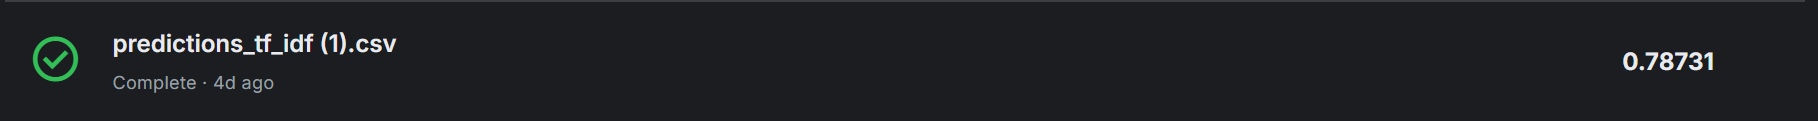
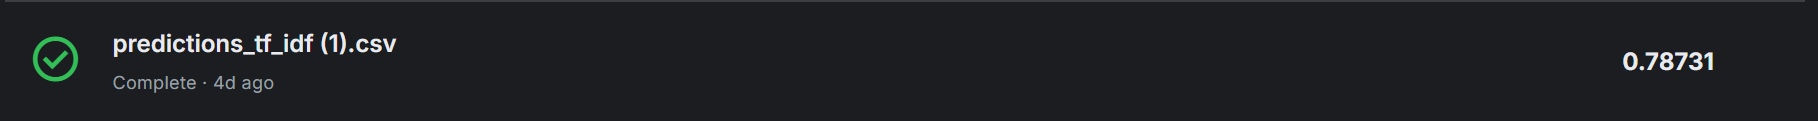

# RNN, LSTM

The same td-idf dataset was used as the date, no other vector representations were used, which is possible (and knowing the result, I think that's for sure) it will affect the result

In [11]:
X_train_tensor = torch.tensor(tf_idf_train.toarray(), dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(tf_idf_test.toarray(), dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(train['target'].values, dtype=torch.long)
y_val_tensor = torch.tensor(test['target'], dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate= 0.3):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        _, hn = self.rnn(x)
        out = self.dropout(hn[-1])
        out = self.fc(out)
        return out

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate= 0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.dropout(hn[-1])
        out = self.fc(out)
        return out

In [13]:
def train_model(model, train_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    return model

In [14]:
input_dim = X_train_tensor.shape[2]
hidden_dim = 128
output_dim = 2
num_layers = 2

rnn_model = RNNClassifier(input_dim, hidden_dim, output_dim, num_layers)
lstm_model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers)

In [15]:
rnn_trained = train_model(rnn_model, train_loader)

Epoch 1, Loss: 0.32328519225120544
Epoch 2, Loss: 0.18187911808490753
Epoch 3, Loss: 0.1859659105539322
Epoch 4, Loss: 0.21242254972457886
Epoch 5, Loss: 0.050800226628780365
Epoch 6, Loss: 0.20191150903701782
Epoch 7, Loss: 0.02817641757428646
Epoch 8, Loss: 0.07127170264720917
Epoch 9, Loss: 0.42838725447654724
Epoch 10, Loss: 0.00911568384617567


In [16]:
lstm_trained = train_model(lstm_model, train_loader)

Epoch 1, Loss: 0.7924928069114685
Epoch 2, Loss: 0.5216608643531799
Epoch 3, Loss: 0.5089721083641052
Epoch 4, Loss: 0.17822101712226868
Epoch 5, Loss: 0.06196733936667442
Epoch 6, Loss: 0.0345333069562912
Epoch 7, Loss: 0.04886048287153244
Epoch 8, Loss: 0.05365728214383125
Epoch 9, Loss: 0.34293943643569946
Epoch 10, Loss: 0.18426741659641266


In [17]:
def evaluate_model(model, X_val_tensor, y_val_tensor):
    with torch.no_grad():
        outputs = model(X_val_tensor)
        predictions = torch.argmax(outputs, dim=1)
        f1 = f1_score(y_val_tensor.numpy(), predictions.numpy())
    return f1

rnn_f1 = evaluate_model(rnn_trained, X_val_tensor, y_val_tensor)
lstm_f1 = evaluate_model(lstm_trained, X_val_tensor, y_val_tensor)

In [18]:
print(rnn_f1)
print(lstm_f1)

0.6841593780369291
0.6914103923647932


LSTM has better results so let's submit it

In [19]:
X_test_tensor = torch.tensor(tf_idf_Test.toarray(), dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    predictions = lstm_trained(X_test_tensor).argmax(dim=1).numpy()

results = pd.DataFrame({
    'id': df_test['id'].values,
    'target': predictions
})

results.to_csv('predictions_lstm.csv', index=False)

### Score
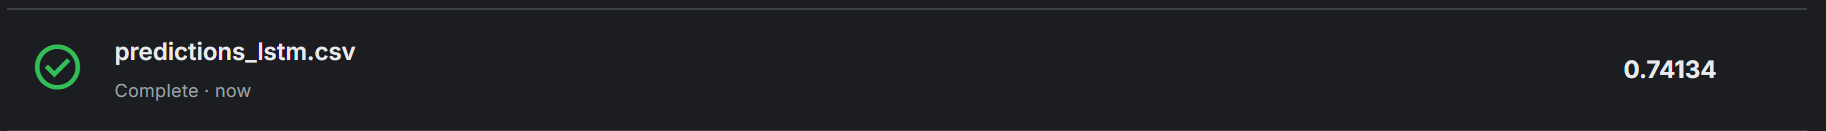

# Pre-trained model

I chose Roberta as the pretrained model, as it is not particularly difficult to use, and it is also claimed to be better than the usual Bert

RobertaTokenizer was also used, as it is more convenient this way.

In [20]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(train['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
test_encodings = tokenizer(test['text'].tolist(), padding=True, truncation=True, return_tensors='pt')
predict_encodings = tokenizer(df_test['text'].tolist(), padding=True, truncation=True, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [21]:
class NewsDataset(torch.utils.data.Dataset):
   def __init__(self, encodings, labels=None):
       self.encodings = encodings
       self.labels = labels

   def __getitem__(self, idx):
       item = {key: val[idx] for key, val in self.encodings.items()}
       if self.labels is not None:
           item['labels'] = torch.tensor(self.labels[idx])
       return item

   def __len__(self):
       return len(self.labels) if self.labels is not None else len(self.encodings['input_ids'])

train_dataset = NewsDataset(train_encodings, train['target'].tolist())
test_dataset = NewsDataset(test_encodings, test['target'].tolist())
predict_dataset = NewsDataset(predict_encodings)

In [22]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(train['target'].unique()))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, optimizer, criterion, device, epochs=10):
    model.train()  
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}')
    return model

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

trained_model = train_model(model, train_loader, optimizer, criterion, device)
trained_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = trained_model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='weighted')

Epoch 1, Loss: 0.4678
Epoch 2, Loss: 0.3528
Epoch 3, Loss: 0.2938
Epoch 4, Loss: 0.2151
Epoch 5, Loss: 0.1643
Epoch 6, Loss: 0.1279
Epoch 7, Loss: 0.0996
Epoch 8, Loss: 0.1014
Epoch 9, Loss: 0.0921
Epoch 10, Loss: 0.0728


In [24]:
f1

0.7934842206476636

In [25]:
predict_loader = DataLoader(predict_dataset, batch_size=16, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in predict_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = trained_model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)
        predictions.extend(preds.cpu().numpy())

In [26]:
results = pd.DataFrame({
    'id': df_test['id'].values,
    'target': predictions
})

results.to_csv('predictions_Roberta.csv', index=False)

### Score
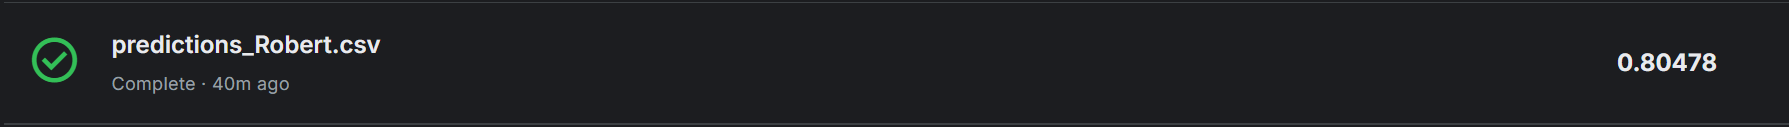

# Conclusions
Roberta showed the best result, followed by classic ML, and neural networks trained from scratch showed the worst result.

I assume that the best result without generating new features can be achieved using a pretrained model, perhaps it makes sense to take a model with a different architecture. 
It also makes sense to use manual tokenization, since the object of research is somewhat specific.

In terms of difficulties, I can say that writing neural networks was not the easiest, and the quality wants to leave the best. Also, pre-trained models are quite expensive in terms of training: